In [14]:
# %load_ext autoreload
# %autoreload 2

import matplotlib.pyplot as plt
from AbundanceMatching import *
import emcee
import numpy as np
import Corrfunc
from Corrfunc.theory import wp
from scipy.stats import multivariate_normal
from galaxy_statistics import generate_wp,comp_deconv_steps,AMLikelihood
from astropy.io import fits
import matplotlib
from tqdm import tqdm

## Abundance Matching (SDSS) - M_star < -21,-20, and -18

In [4]:
data_path = '/u/ki/rmredd/data/'
# Luminosity function
# lf_21 = np.loadtxt(data_path + 'lf/tinker/lf_jt_21.dat')
lf_20 = np.loadtxt(data_path + 'lf/tinker/lf_jt_20.dat')
lf_18 = np.loadtxt(data_path + 'lf/tinker/lf_jt_18.dat')
# lf_21 = lf_21[lf_21[:,1]>0,:]
lf_20 = lf_20[lf_20[:,1]>0,:]
lf_18 = lf_18[lf_18[:,1]>0,:]

wp_path = '/u/ki/rmredd/data/corr_wp/tinker_sdss_wp/'
wp_20 = np.loadtxt(wp_path + 'wp_20.dat')
wp_20_cov_temp = np.loadtxt(wp_path + 'wp_covar_20.dat')
wp_20_cov = np.zeros((len(wp_20),len(wp_20)))
for wp_tup in wp_20_cov_temp:
    wp_20_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_20_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
wp_18 = np.loadtxt(wp_path + 'wp_18.dat')
wp_18_cov_temp = np.loadtxt(wp_path + 'wp_covar_18.dat')
wp_18_cov = np.zeros((len(wp_18),len(wp_18)))
for wp_tup in wp_18_cov_temp:
    wp_18_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_18_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
wp_21 = np.loadtxt(wp_path + 'wp_21.dat')
wp_21_cov_temp = np.loadtxt(wp_path + 'wp_covar_21.dat')
wp_21_cov = np.zeros((len(wp_21),len(wp_21)))
for wp_tup in wp_21_cov_temp:
    wp_21_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_21_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
r_cutoff = 15

wp_20_cov=wp_20_cov[wp_20[:,0]<r_cutoff,:]
wp_20_cov=wp_20_cov[:,wp_20[:,0]<r_cutoff]
wp_20_var = np.diag(wp_20_cov)
wp_20 = wp_20[wp_20[:,0]<r_cutoff]

wp_18_cov=wp_18_cov[wp_18[:,0]<r_cutoff,:]
wp_18_cov=wp_18_cov[:,wp_18[:,0]<r_cutoff]
wp_18_var = np.diag(wp_18_cov)
wp_18 = wp_18[wp_18[:,0]<r_cutoff]

wp_21_cov=wp_21_cov[wp_21[:,0]<r_cutoff,:]
wp_21_cov=wp_21_cov[:,wp_21[:,0]<r_cutoff]
wp_21_var = np.diag(wp_21_cov)
wp_21 = wp_21[wp_21[:,0]<r_cutoff]

box_size = 400
pimax = 40.0
scatters = [0.1,0.2,0.3]
deconv_repeat = 200
mag_cuts=[-21.0,-20.0,-18.0]
# Use lf_20 twice since we don't have an lf_21
lf_list = [lf_20,lf_20,lf_18]

# Halos from n body sim
halo_path = '/nfs/slac/des/fs1/g/sims/jderose/BCCSims/c400-2048/'
halos = np.array(fits.open(halo_path + 'hlist_1.00000.list.fits')[1].data)
r_p_data = wp_20[:,0]
wp_data_list = [wp_21[:,0],wp_20[:,0],wp_18[:,0]]
wp_cov_list = [wp_21_cov,wp_20_cov,wp_18_cov]
nthreads = 1

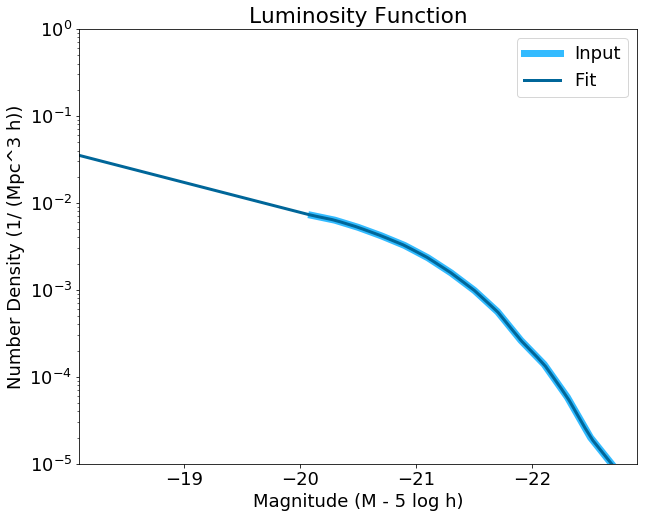

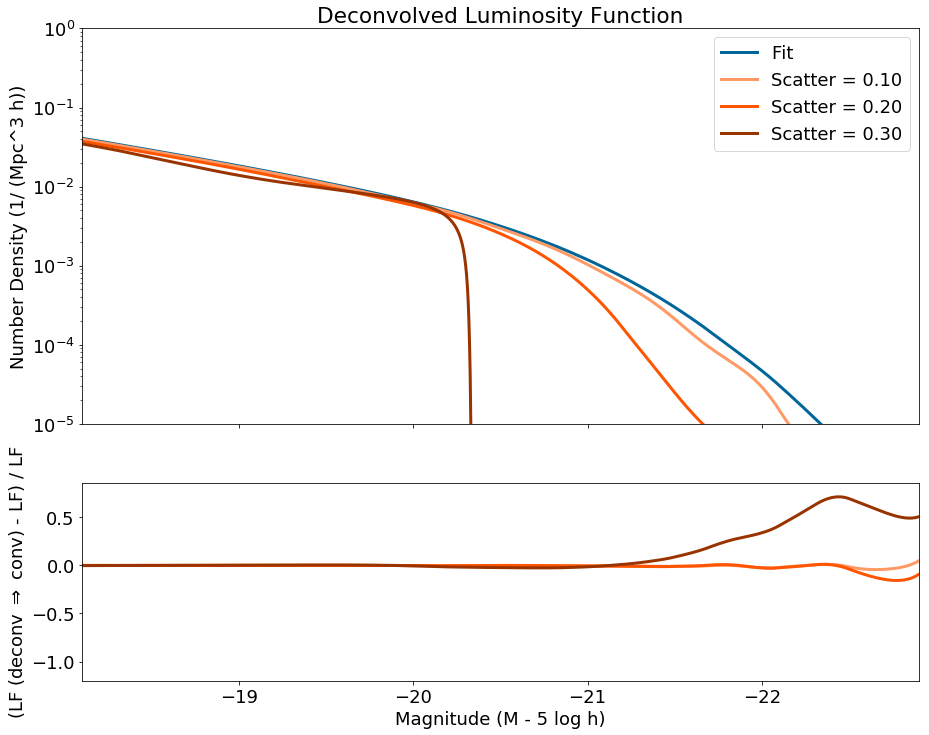

Scatter 0.10 catalog has 75713 galaxies


/u/ki/swagnerc/.local/lib/python3.7/site-packages/Corrfunc-2.3.1-py3.7-linux-x86_64.egg/Corrfunc/utils.py:916: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Scatter 0.20 catalog has 75431 galaxies
Scatter 0.30 catalog has 75014 galaxies


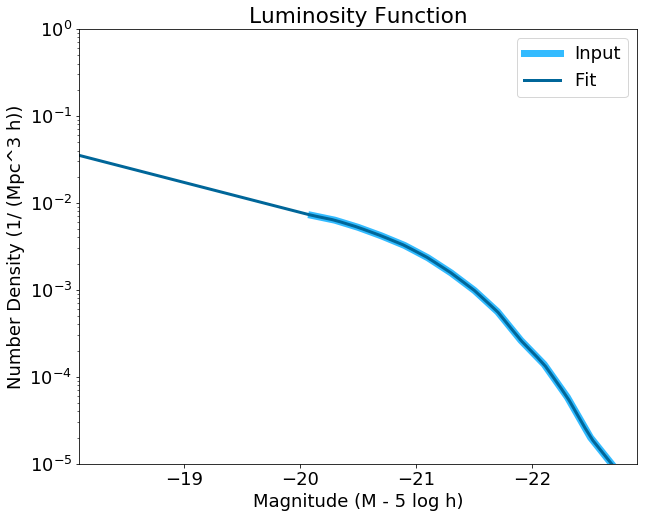

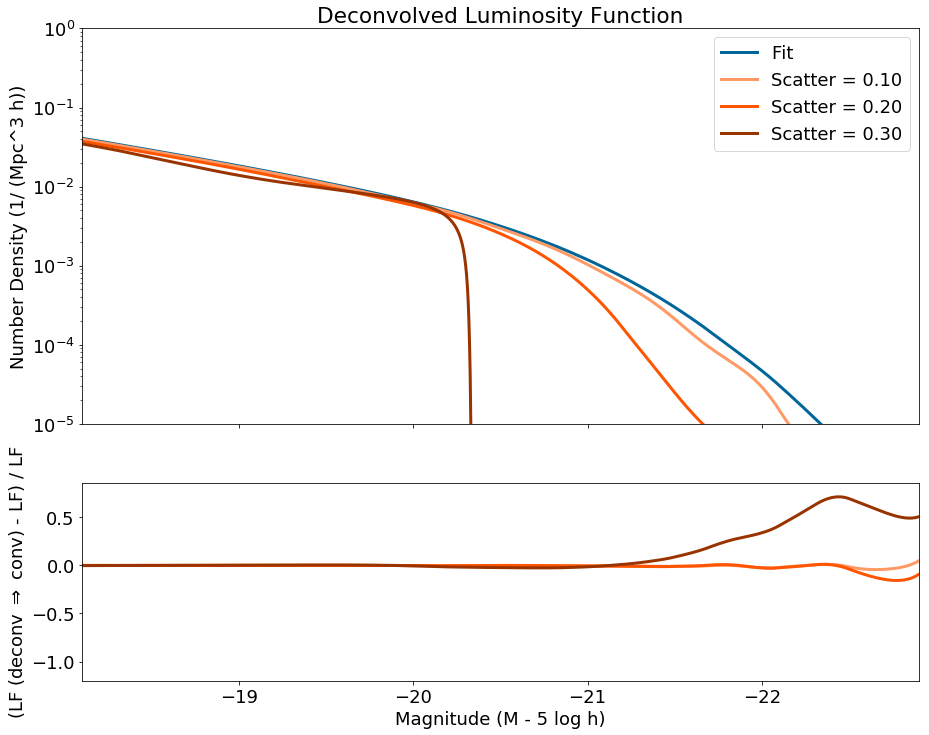

Scatter 0.10 catalog has 409448 galaxies
Scatter 0.20 catalog has 408331 galaxies
Scatter 0.30 catalog has 407893 galaxies


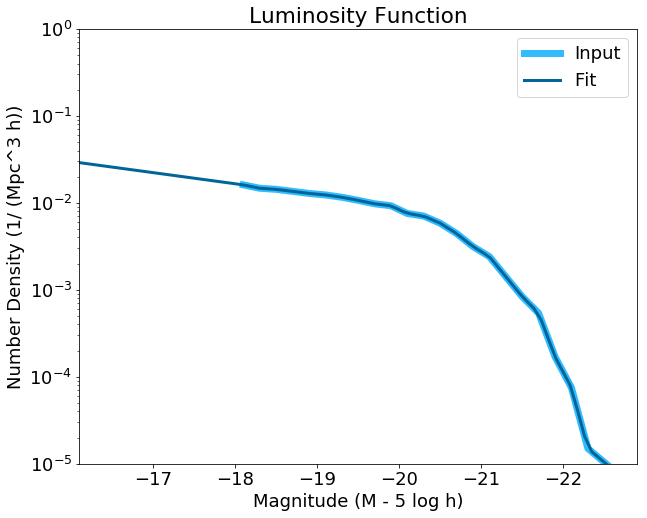

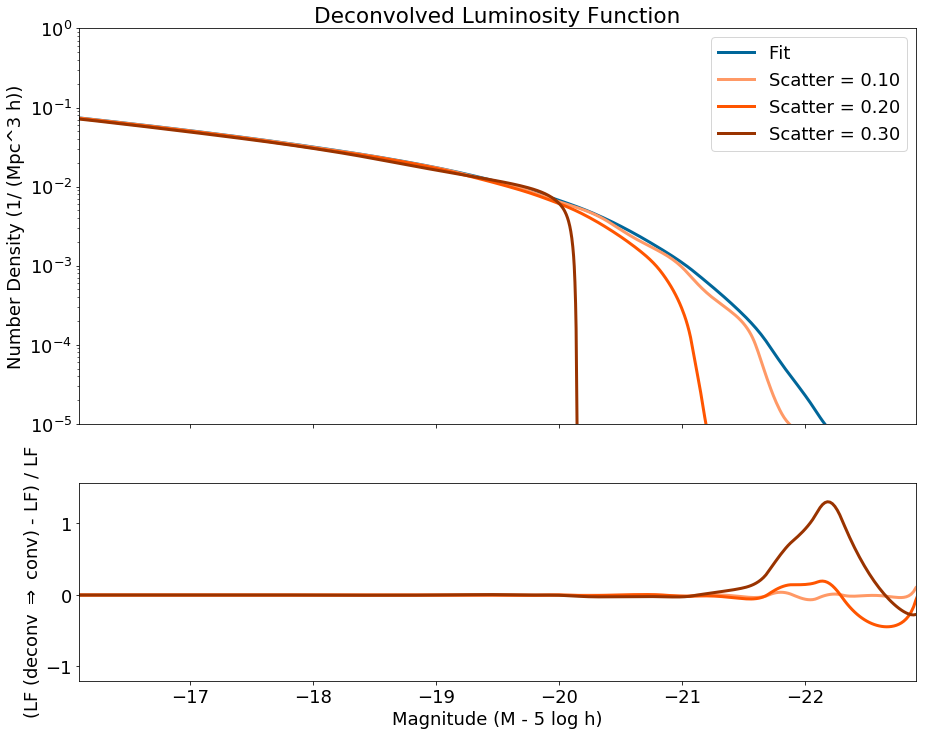

Scatter 0.10 catalog has 2026834 galaxies
Scatter 0.20 catalog has 2027085 galaxies
Scatter 0.30 catalog has 2029004 galaxies


In [4]:
wp_binneds = generate_wp(lf_list,halos,'vmax',wp_20[:,0],box_size,mag_cuts=mag_cuts,pimax=pimax,scatters=scatters,
                    deconv_repeat=deconv_repeat,verbose=True)

chi^2 is -162.907755


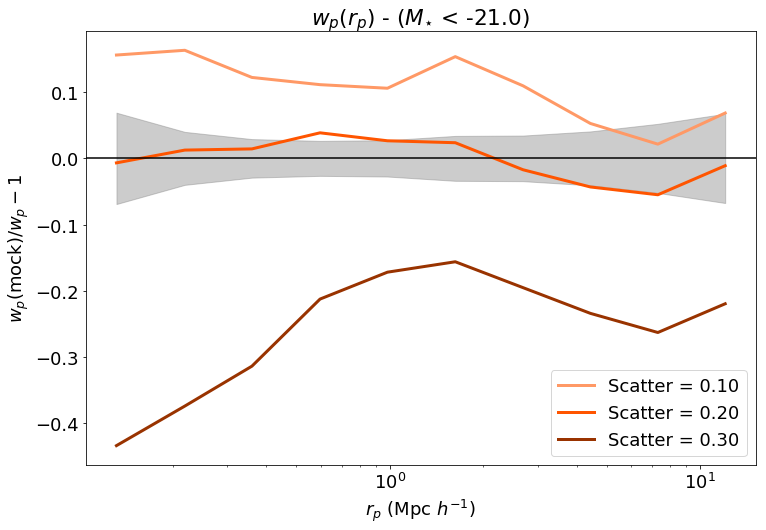

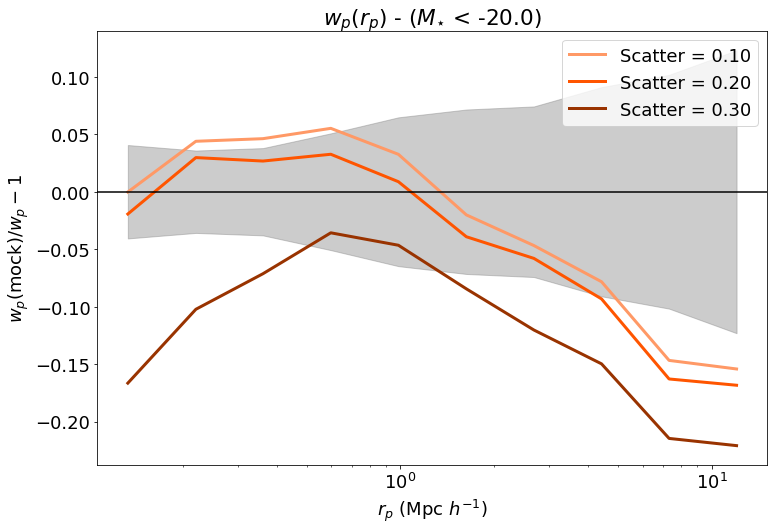

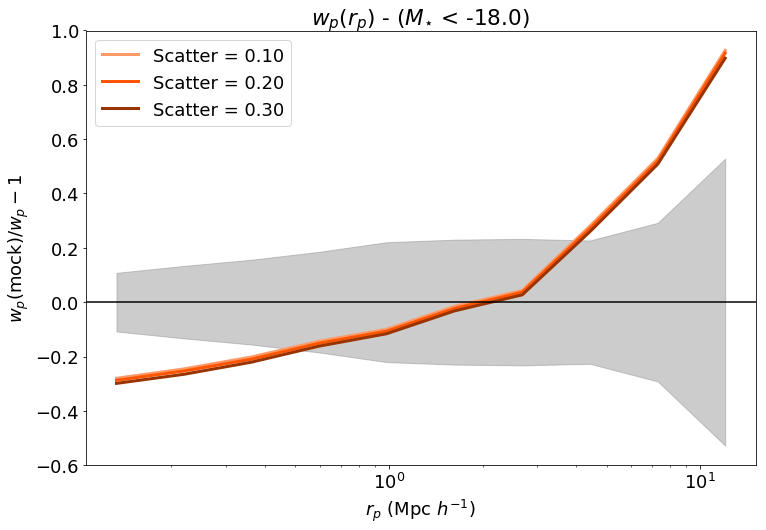

In [5]:
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300","#662200"]

# M_star < -21
plt.figure(figsize=(12,8))
legend = []
for wp_binned in wp_binneds[0]:
    plt.plot(wp_21[:,0],wp_binned/wp_21[:,1]-1,lw=3,c=custom_blues_complement[2*len(legend)])
    legend.append('Scatter = %.2f'%(scatters[len(legend)]))
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.legend(legend)
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')

# M_star < -20
plt.figure(figsize=(12,8))
legend = []
for wp_binned in wp_binneds[1]:
    plt.plot(wp_20[:,0],wp_binned/wp_20[:,1]-1,lw=3,c=custom_blues_complement[2*len(legend)])
    legend.append('Scatter = %.2f'%(scatters[len(legend)]))
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[1]))
plt.legend(legend)
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')

# M_star < -18
plt.figure(figsize=(12,8))
legend = []
for wp_binned in wp_binneds[2]:
    plt.plot(wp_18[:,0],wp_binned/wp_18[:,1]-1,lw=3,c=custom_blues_complement[2*len(legend)])
    legend.append('Scatter = %.2f'%(scatters[len(legend)]))
plt.fill_between(wp_18[:,0],-np.sqrt(wp_18_var)/wp_18[:,1],np.sqrt(wp_18_var)/wp_18[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[2]))
plt.legend(legend)
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')

print('chi^2 is %f'%(multivariate_normal.logpdf(wp_binned,wp_20[:,1],wp_20_cov)))

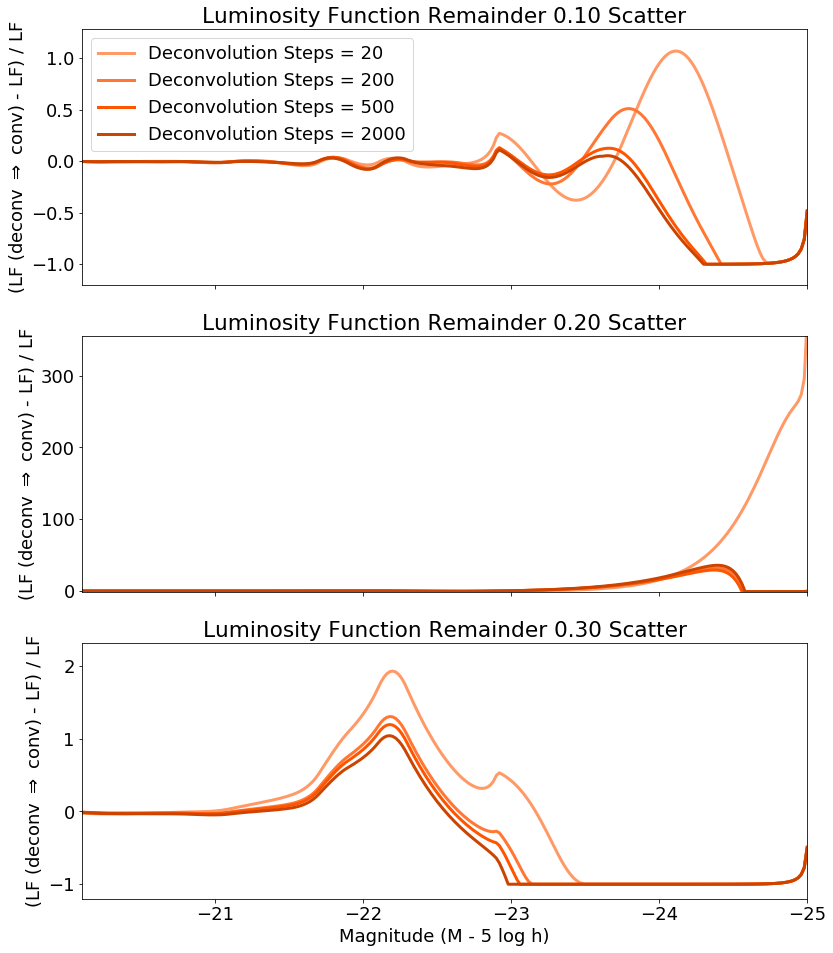

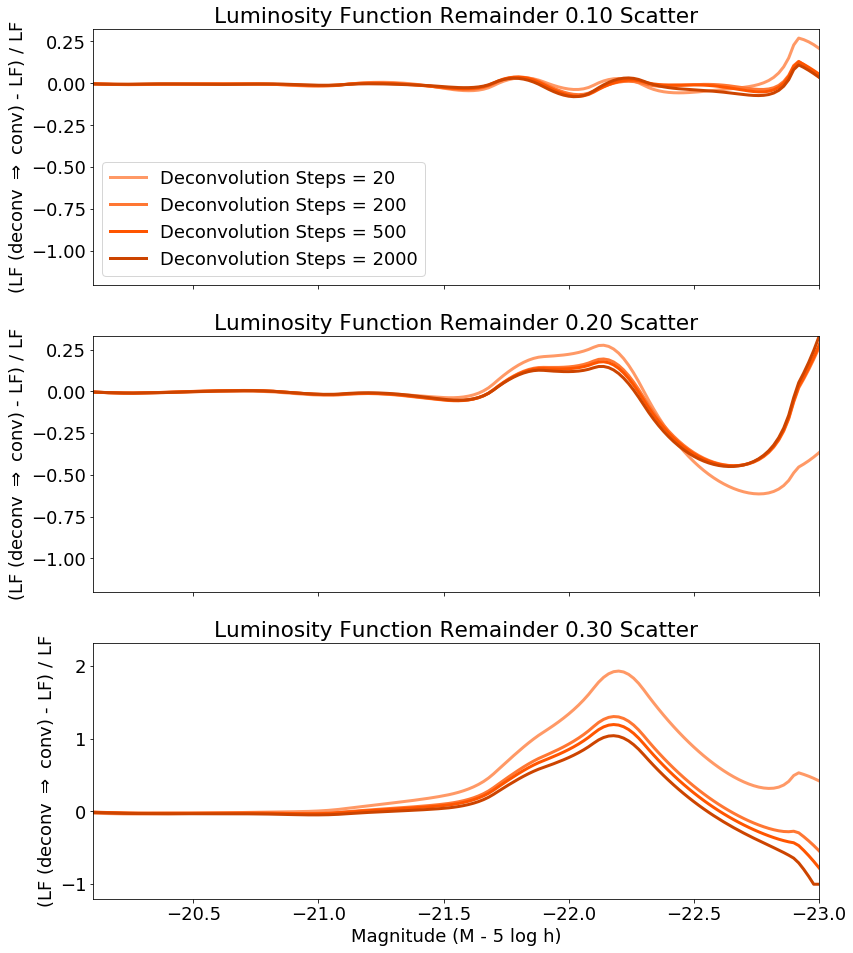

In [39]:
deconv_repeats = [20,200,500,2000]
comp_deconv_steps(lf_18,scatters,deconv_repeats,m_max=-25)
comp_deconv_steps(lf_18,scatters,deconv_repeats,m_max=-23)

### Test the likelihood function code

In [26]:
lf_list = [lf_20,lf_20]
wp_data_list = [wp_21[:,1],wp_20[:,1]]
wp_cov_list = [wp_21_cov,wp_20_cov]
wp_save_path = '/u/ki/swagnerc/abundance_matching/wp_results/wp'
like_class = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,nthreads,
                         deconv_repeat,wp_save_path)

In [16]:
scatter = 0.15
mu_cut = 0.1
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class.log_likelihood([scatter,mu_cut],verbose=False)))

# scatter = 0.2
# mu_cut = 0.0
# print('Scatter %.2f, mu_cut %.2f, ll %.2f'%(scatter,mu_cut,like_class.log_likelihood([scatter,mu_cut],verbose=False)))

# scatter = 0.2
# mu_cut = 0.1
# print('Scatter %.2f, mu_cut %.2f, ll %.2f'%(scatter,mu_cut,like_class.log_likelihood([scatter,mu_cut],verbose=False)))

# scatter = 0.3
# mu_cut = 0.0
# print('Scatter %.2f, mu_cut %.2f, ll %.2f'%(scatter,mu_cut,like_class.log_likelihood([scatter,mu_cut],verbose=False)))

Scatter 0.15, mu_cut 0.10, ll -0.00000


In [27]:
n_params = 2; n_walkers = 20;
n_steps = 1000
pos = np.random.rand(n_params*n_walkers).reshape((n_walkers,n_params))*0.3
def test_like(params):
    return -np.sum(np.square(params-np.array([0.2,0.1]))/0.00001)
sampler = emcee.EnsembleSampler(n_walkers, n_params, test_like, threads=6)

In [30]:
import csv   
fields=['scatter','mu_cut']
with open(r'name', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    save_step = 10
    for step in tqdm(range(n_steps//save_step)):
        pos, _, _ = sampler.run_mcmc(pos, save_step)
        if step > 100//save_step:
            writer.writerows(sampler.chain[:,-10:,:].reshape(-1,n_params))


100%|██████████| 100/100 [00:06<00:00, 14.77it/s]

In [23]:
import pandas as pnd
csv_path = '/u/ki/swagnerc/abundance_matching/wp_results/mc_chains.csv'
chains = pnd.read_csv(csv_path)

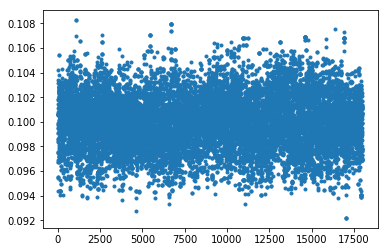

In [24]:
plt.plot(chains['mu_cut'],'.')

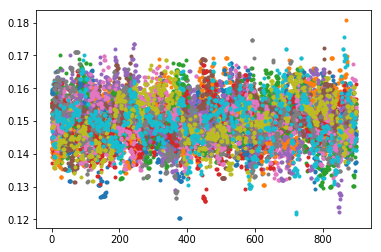

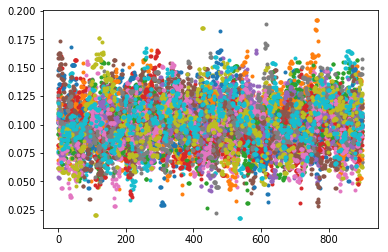

In [108]:
chains = sampler.chain[:,100:,:]
for chain in chains:
    plt.plot(chain[:,0],'.')
plt.show()
for chain in chains:
    plt.plot(chain[:,1],'.')
plt.show()

In [107]:
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300","#662200"]
wp_tests = np.loadtxt('toss_path_2000000_wp.txt')
params = np.loadtxt('toss_path_2000000_p.txt')
print(params)
plt.figure(figsize=(12,8))
plt.plot(wp_21[:,0],wp_tests[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[2])
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(wp_20[:,0],wp_tests[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[2])
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')
plt.show()

OSError: toss_path_2000000_wp.txt not found.

In [ ]:
import emcee